# 传统方式
需求：北京明天的天气怎么样？上海呢？ （通过两次对话实现）

## 方式1：ReAct模式

In [7]:
import os

import dotenv
from langchain_classic.agents import initialize_agent, AgentType
from langchain_classic.memory import ConversationBufferMemory
from langchain_community.tools.tavily_search import TavilySearchResults
# 1. 导入依赖包
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()

# 2. 设置搜索工具APIKEY
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# 3. 定义搜索工具
search = TavilySearchResults(max_result=2)
# 4.定义大模型
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# 定义记忆存储组件
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)    # 这里记忆存储的key必须指定 `chat_history`
# 创建Agent
agent = AgentType.CONVERSATIONAL_REACT_DESCRIPTION
# 创建AgentExecutor
agent_executor = initialize_agent(
    tools=[search],
    llm=llm,
    agent=agent,
    verbose=True,
    memory=memory,
    handle_parsing_errors=True
)
# 调用执行器
result = agent_executor.invoke({"input": "北京明天的天气怎么样？"})
print(result)



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: tavily_search_results_json
Action Input: 北京 明天的天气
```
Observation: [{'title': '中国气象局-天气预报- 北京', 'url': 'https://weather.cma.cn/web/weather/', 'content': '|  |  |  |  |  |  |  |  |  |\n ---  ---  ---  --- \n| 时间 | 11:00 | 14:00 | 17:00 | 20:00 | 23:00 | 02:00 | 05:00 | 08:00 |\n| 天气 |  |  |  |  |  |  |  |  |\n| 气温 | 24.2℃ | 28.3℃ | 28.8℃ | 26.1℃ | 23.8℃ | 23.4℃ | 22.2℃ | 25.3℃ |\n| 降水 | 2.3mm | 2.3mm | 2.3mm | 2.3mm | 0.9mm | 无降水 | 0.7mm | 无降水 |\n| 风速 | 3.1m/s | 3.3m/s | 3.3m/s | 2.6m/s | 2.8m/s | 3m/s | 3.3m/s | 3.3m/s |\n| 风向 | 东北风 | 西南风 | 东南风 | 西南风 | 西南风 | 东南风 | 东北风 | 东南风 | [...] |  |  |  |  |  |  |  |  |  |\n ---  ---  ---  --- \n| 时间 | 08:00 | 11:00 | 14:00 | 17:00 | 20:00 | 23:00 | 02:00 | 05:00 |\n| 天气 |  |  |  |  |  |  |  |  |\n| 气温 | 25.9℃ | 27.7℃ | 30.8℃ | 29.4℃ | 27.4℃ | 26℃ | 24.2℃ | 25.4℃ |\n| 降水 | 无降水 | 2.3mm | 2.3mm | 2.3mm | 2.3mm | 无降水 | 无降水 | 1.9mm |\n| 风速 | 3.2m/s | 3.2m/s | 3.3m

再次对话，检查有无上下文记忆：

In [8]:
result = agent_executor.invoke({"input": "上海呢？"})
print(result)



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: tavily_search_results_json
Action Input: 上海明天的天气预报
```
Observation: [{'title': '上海 - 中国气象局-天气预报-城市预报', 'url': 'https://weather.cma.cn/web/weather/58367.html', 'content': '|  |  |  |  |  |  |  |  |  |\n ---  ---  ---  --- \n| 时间 | 05:00 | 08:00 | 11:00 | 14:00 | 17:00 | 20:00 | 23:00 | 02:00 |\n| 天气 |\n| 气温 | 16.6℃ | 17.9℃ | 21.1℃ | 21.8℃ | 19.5℃ | 18.9℃ | 18.8℃ | 17.6℃ |\n| 降水 | 无降水 | 无降水 | 无降水 | 无降水 | 无降水 | 无降水 | 无降水 | 无降水 |\n| 风速 | 3.3m/s | 3.1m/s | 3.2m/s | 3.3m/s | 3m/s | 3m/s | 3.3m/s | 3.2m/s |\n| 风向 | 西北风 | 西北风 | 东北风 | 东北风 | 东北风 | 东北风 | 东北风 | 东北风 |\n| 气压 | 1024.4hPa | 1025.4hPa | 1025.1hPa | 1023.6hPa | 1023.9hPa | 1025.2hPa | 1025.2hPa | 1024hPa | [...] |  |  |  |  |  |  |  |  |  |\n ---  ---  ---  --- \n| 时间 | 08:00 | 11:00 | 14:00 | 17:00 | 20:00 | 23:00 | 02:00 | 05:00 |\n| 天气 |\n| 气温 | 17.8℃ | 21.3℃ | 20.8℃ | 20.4℃ | 19.6℃ | 17.6℃ | 15.8℃ | 15.8℃ |\n| 降水 | 无降水 | 无降水 | 无降水 | 无降水 | 无降水 |

**说明：**

1、为什么`ConversationBufferMemory()`函数里必须指定memory_key为`chat_history`？

因为AgentType对应的CONVERSATIONAL_REACT_DESCRIPTION的提示词里有指定3个变量：`input`、`agent_scratchpad`、`chat_history`，如下图：

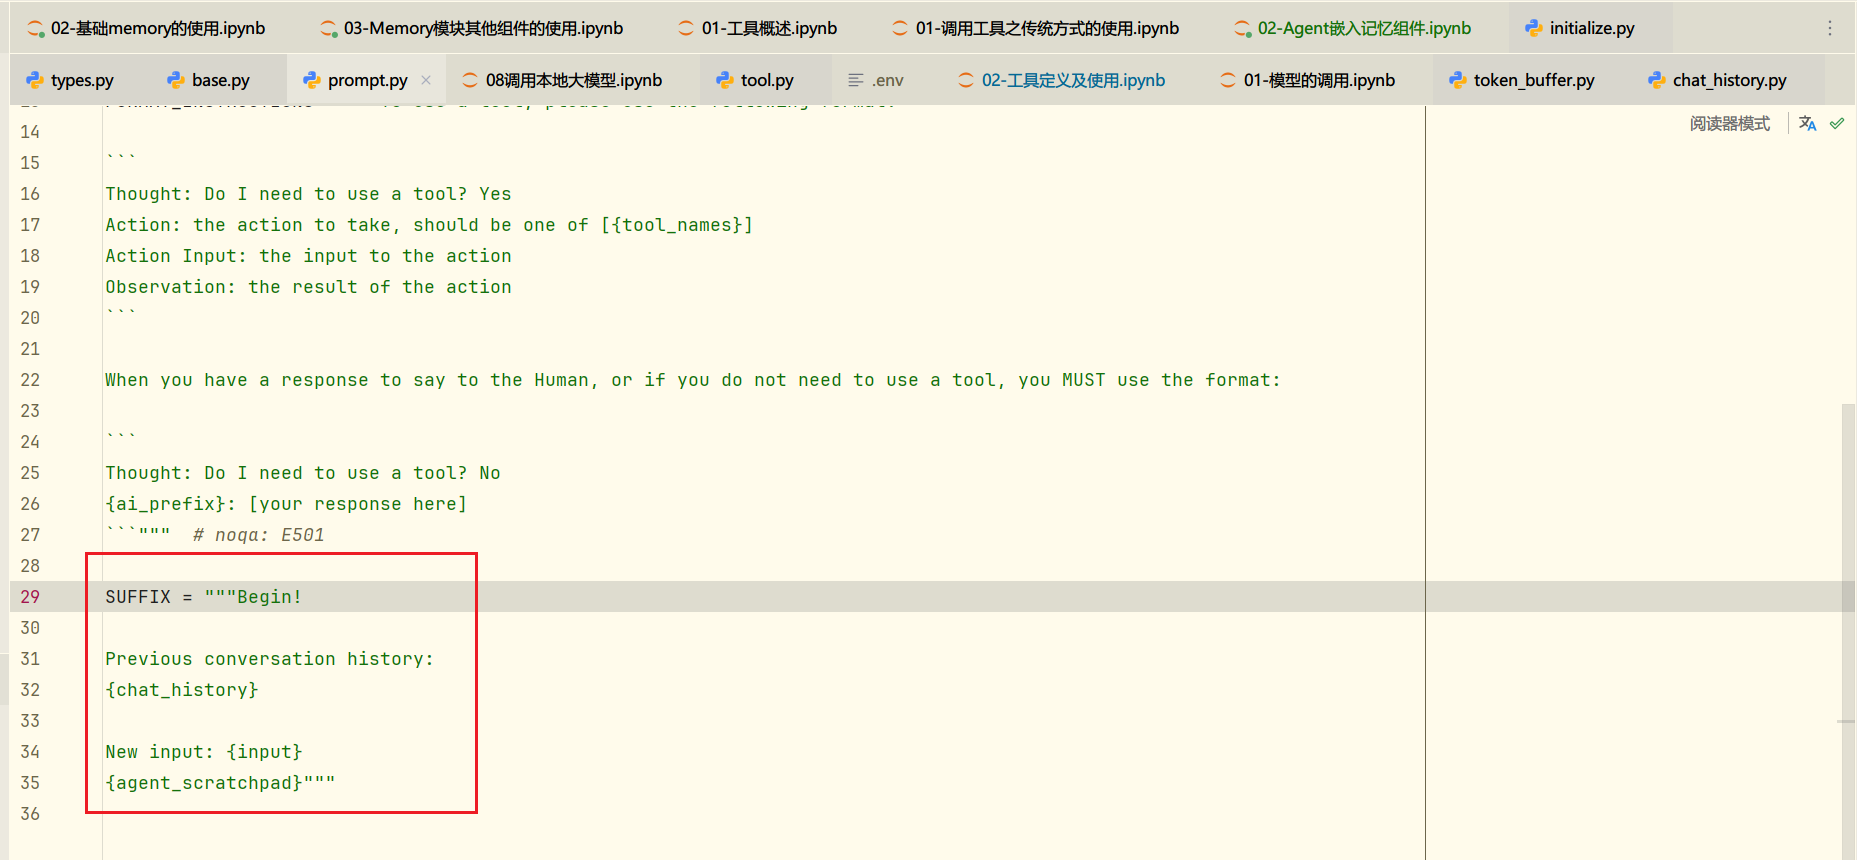

## 方式2：Function_Call模式
现在传统方式（AgentType）好像不支持通过`AgentType.OPENAI_FUNCTIONS`来创建Agent，会报错：

TypeError: langchain_core.language_models.chat_models.BaseChatModel.generate_prompt() got multiple values for keyword argument 'callbacks'

推荐使用通用方式（create_openai_functions_agent）来创建function_call模式的Agent

In [9]:
import os

import dotenv
from langchain_classic.agents import initialize_agent, AgentType
from langchain_classic.memory import ConversationBufferMemory
from langchain_community.tools.tavily_search import TavilySearchResults
# 1. 导入依赖包
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()

# 2. 设置搜索工具APIKEY
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# 3. 定义搜索工具
search = TavilySearchResults(max_result=2)
# 4.定义大模型
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_BASE_URL'] = os.getenv("OPENAI_BASE_URL")
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# 定义记忆存储组件
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)    # 这里记忆存储的key必须指定 `chat_history`
# 创建Agent
agent = AgentType.OPENAI_FUNCTIONS
# 创建AgentExecutor
agent_executor = initialize_agent(
    tools=[search],
    llm=llm,
    agent=agent,
    verbose=True,
    memory=memory,
    handle_parsing_errors=True
)
# 调用执行器
result = agent_executor.invoke({"input": "北京明天的天气怎么样？"})
print(result)



> Entering new AgentExecutor chain...


TypeError: langchain_core.language_models.chat_models.BaseChatModel.generate_prompt() got multiple values for keyword argument 'callbacks'